In [1]:
%matplotlib notebook

import pathlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wms.dbs import weadbs, hdf5
from wms.analysis import classification, damage, plots
from wms.utils import periods
import bchdf

Using bladecontrol plotting style.
Registering webvis-style.


In [498]:
import importlib
import bchdf.bchdf

importlib.reload(bchdf.bchdf)
importlib.reload(bchdf)
importlib.reload(hdf5)
importlib.reload(weadbs)

<module 'wms.dbs.weadbs' from 'u:\\wms-python\\wms\\dbs\\weadbs.py'>

# Example of how to specify a damage case

### necessary information
needed for creating a damage classifier

In [2]:
# database name for the considered turbine
db = 'bc_t_02491'

# the damaged blade
dmg_blade = 3

# the blades without damage throughout the considered period (data_periods below)
# (we usually don't want to compare with data from a different damage case)
ok_blades = [1, 2]

# period in which the damage was present for sure
#   - it is unclear from when
#   - start = first SDA-warning in 150-350 Hz after that it occurred 
dmg_period = ('2019-12-11', '2020-06-19')

# Period in which the turbine was stopped due to damage. Actually stopped already 
# from 2020-01-09 08:00, but only after 12:30 pitch was > 90°. There are 
# measurements with pitch < 90° in between in this period, but they are rare.
# Flagging this period specifically, because signal energies in the ok blades 
# were on average markedly reduced during this shutdown even compared to cycles
# with similar pitch and wind measurements.
shutdown_period = ('2020-01-09 12:30', '2020-06-19')

# the full time period that should be investigated
# use this to restrict data to those periods with comparable 
# measurement conditions, e.g., same installed sensors, same turbine hardware
# also use this to exclude times with otherwise abnormal data, e.g., 
# repair times, or perhaps a different unrelated damage
# you can give several periods in a list
data_periods = [('2019', '2021')]

# periods in which given sensors were defect
# blade 3 sensors destroyed during repair
sens_defects = {'3_edge': [('2020-06-19', '2020-10-17')],
                '3_flap': [('2020-06-19', '2020-10-17')]}

In [3]:
hdfdir = pathlib.Path(f'D:/damages/V136_Hinterkante/{db}/_current')

### optional information
these may, or may not be used to create a damage classifier

In [4]:
# normalisation instructions known to result in damage seen in data
# see wms.dbs.weadbs.SEData.normalise for options
normalisation = dict(normhow='div')

# frequency bands in which the damage is seen (if previously identified,
# but this will most likely be ignored during classifier generation)
fbands = pd.IntervalIndex.from_breaks(np.arange(0, 501, 2))

### Peaks and troughs from mean spectograms

In [5]:
fbands = dict(
    edge=[0, 0.34, 0.85, 1.15, 2.35, 2.8, 3.25, 4.8, 5.2, 6, 6.5, 8.5, 9.1, 
          10, 10.9, 13.6, 14.5, 15.2, 15.8, 18, 18.9, 19.6, 20.8, 22.9, 23.7,
          28, 28.9, 30.2, 31.3, 32.3, 33.7, 34.6, 36, 36.9, 38, 39.3, 40.5, 42, 
          43.6, 46.7, 48.3, 50, 52, 53.8, 55, 59.5, 62, 65, 67, 71.5, 73.3, 75,
          76.4, 78.8, 79.8, 81.6, 83.3, 86, 89, 99.7, 100.4, 102.9, 105, 110,
          112.5, 116, 120, 125, 129, 131, 136, 143.5, 149.3, 150.7, 154, 158,
          161.5, 165, 167.5, 170, 173.5, 177, 180.5, 188, 192, 195, 197, 204,
          212, 216.5, 222, 228, 230.5, 242, 247, 252, 265, 273, 299.7, 300.5,
          318, 320, 324, 325.5, 340, 346, 349.5, 350.5, 378, 392, 399.5, 400.5,
          420, 430, 442, 452, 467, 479, 483, 492, 500],
    flap=[0, 0.34, 0.6, 0.85, 1.15, 1.7, 2.3, 2.7, 3.2, 3.7, 4.75, 5.2, 
          5.5, 6.2, 7.35, 8, 8.7, 8.85, 9.1, 11.05, 11.5, 12.95, 13.4, 14.4,
          15.2, 15.7, 16.2, 17, 18.5, 18.9, 20, 20.6, 22.2, 23, 23.6, 24.2, 25.1,
          28.3, 28.9, 30.2, 33.5, 37.2, 39, 40.5, 42.9, 45, 48.3, 50, 51.9,
          53.6, 55, 58.3, 61.2, 63.9, 66.7, 68, 69.5, 70.6, 71.9, 75, 76.4,
          77.5, 79, 80, 81.3, 82.8, 84.5, 85.8, 86.7, 91.2, 92.8, 96.8, 99.7,
          100.4, 108, 117, 119.5, 123, 131, 133.5, 138, 144.5, 149.3, 150.7,
          158, 161, 169, 171.5, 174.5, 178.5, 182, 187, 192, 196, 203, 207, 
          210, 213, 221, 223.5, 230.5, 244, 252, 265, 273, 299.7, 300.5,
          318, 320, 324, 325.5, 340, 346, 349.5, 350.5, 378, 392, 399.5, 400.5,
          420, 430, 442, 452, 467, 479, 483, 492, 500])

In [4]:
fbands = np.r_[np.arange(0, 20, 0.2), np.arange(20, 100, 0.5),
               np.arange(100, 200, 1), np.arange(200, 300, 2),
               np.arange(300, 500, 5)]

## Data conversions

In [650]:
loader = hdf5.HDFSpecs2sda(hdfdir, hdfdir / 'sda_from_specs.h5', 
                           fbands=fbands, min_itemsize={'timezone': 4})
_cts = loader.load(('2019', '2020-01-09'), dt=pd.Timedelta(days=60), verbose=1)

using file bc_t_02491_af_0
loading data for (2018-12-31 23:00:00.000000001+00:00, 2019-03-01 23:00:00.000000001+00:00)
loading data for (2019-03-01 23:00:00.000000001+00:00, 2019-04-30 23:00:00.000000001+00:00)
loading data for (2019-04-30 22:13:39.000000001+00:00, 2019-06-29 22:13:38.000000001+00:00)
loading data for (2019-06-29 21:31:02.000000001+00:00, 2019-08-28 21:31:01.000000001+00:00)
loading data for (2019-08-28 21:24:50.000000001+00:00, 2019-10-27 21:24:49.000000001+00:00)
loading data for (2019-10-27 20:29:40.000000001+00:00, 2019-12-26 20:29:39.000000001+00:00)
loading data for (2019-12-26 20:20:19.000000001+00:00, 2020-01-08 23:00:00.000000001+00:00)
loading data for (2019-12-31 04:36:35.000000001+00:00, 2020-01-08 23:00:00.000000001+00:00)
using file bc_t_02491_af_1
loading data for (2019-12-31 05:02:32.000000001+00:00, 2020-01-08 23:00:00.000000001+00:00)
loading data for (2020-01-08 22:29:35.000000001+00:00, 2020-01-08 23:00:00.000000001+00:00)
optimising sda_from_specs 

## Overview over SDA

In [653]:
specsed = weadbs.SEData.from_hdf(hdfdir / 'sda_from_specs.h5', 
                                 where={'omega_mean': (0.05,)}).select_channels('blades')

<IPython.core.display.Javascript object>


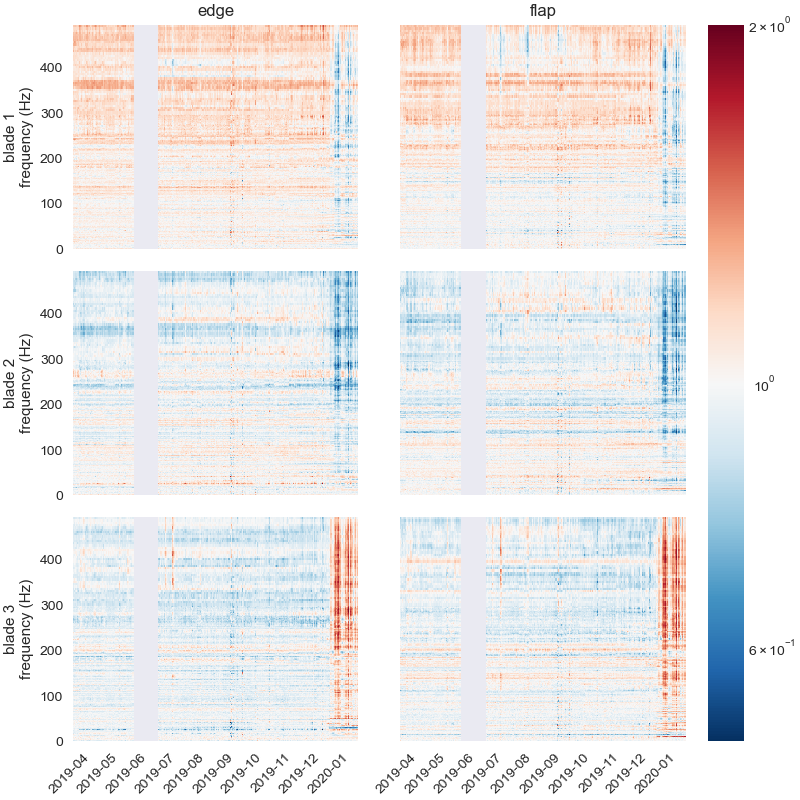

In [655]:
fig, axes = (specsed
             .plot_allse_timecourse(normkws={'normhow': 'div'}, resample='D'))

## BladeDamage class and DI2

In [660]:
dmg = damage.BladeDamage(
    db, hdfdir / 'sda_from_specs.h5', dmg_period, dmg_blade, 
    [('2019', '2020-01-09')], sens_defects)

### Flap

processing wind bin 18 / 18 ...done.


<IPython.core.display.Javascript object>


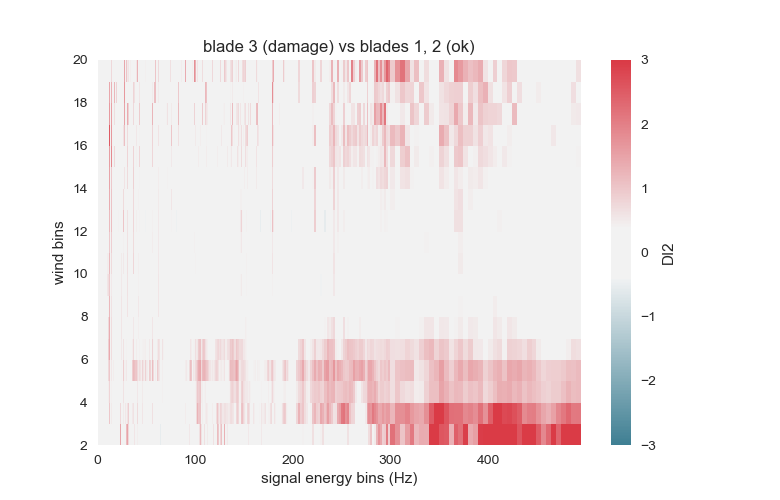

In [666]:
dmg.compute_se_DI2_profile(
    'flap', 'wind_mean', vmin=2, vmax=20, vstep=1,
    where={'omega_mean': (0.05,)}, difference_statistic='cohen_d',
    show=dict(vmin=0.4, vmax=3))

processing omega bin  2 / 16 ...

u:\wms-python\wms\analysis\damage.py:515: RuntimeWarning: There are channels without data in certain periods - subsampling will not work as intended! (1_flap: damage, 1_flap: after, 2_flap: damage, 2_flap: after, 3_flap: damage, 3_flap: after)
  for ind in nodata])), RuntimeWarning)


processing omega bin 16 / 16 ...done.


<IPython.core.display.Javascript object>


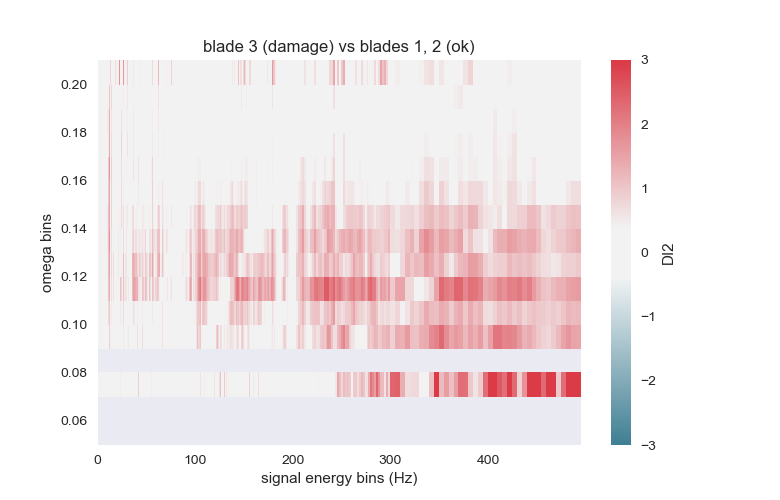

In [667]:
dmg.compute_se_DI2_profile(
    'flap', 'omega_mean', vmin=0.05, vmax=0.21, vstep=0.01,
    difference_statistic='cohen_d', show=dict(vmin=0.4, vmax=3))

<IPython.core.display.Javascript object>


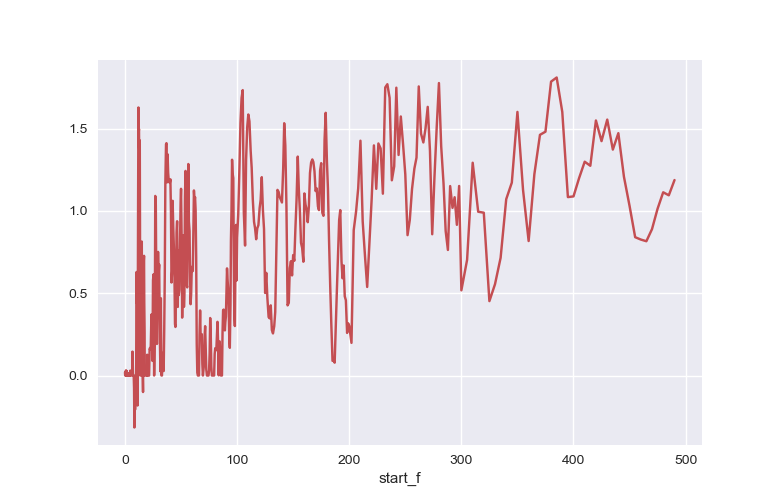

In [668]:
dmg.load_se({'omega_mean': (0.11, 0.13)}, 'flap')
_DI2, _ = dmg.compute_DI2(difference_statistic='cohen_d')

plt.figure()
ax = _DI2.plot()

<IPython.core.display.Javascript object>


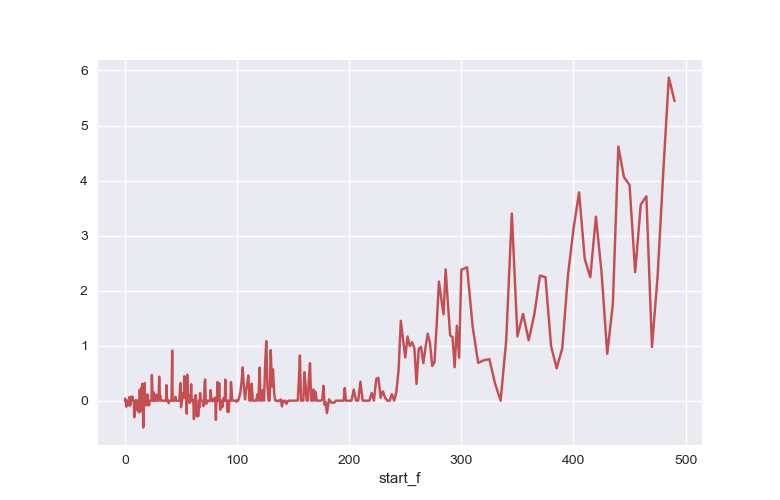

In [669]:
dmg.load_se({'omega_mean': (0.07, 0.08)}, 'flap')
_DI2, _ = dmg.compute_DI2(difference_statistic='cohen_d')

plt.figure()
ax = _DI2.plot()

### Edge

processing wind bin 18 / 18 ...done.


<IPython.core.display.Javascript object>


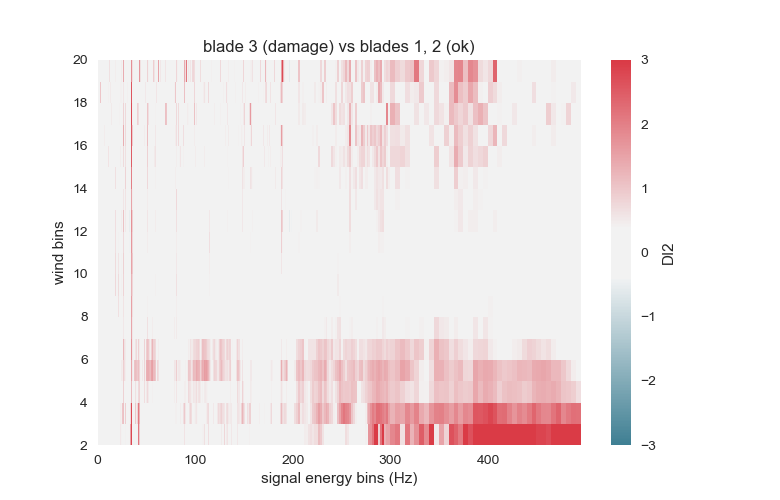

In [672]:
dmg.compute_se_DI2_profile(
    'edge', 'wind_mean', vmin=2, vmax=20, vstep=1,
    where={'omega_mean': (0.05,)}, difference_statistic='cohen_d',
    show=dict(vmin=0.4, vmax=3))

processing omega bin  2 / 16 ...

u:\wms-python\wms\analysis\damage.py:515: RuntimeWarning: There are channels without data in certain periods - subsampling will not work as intended! (1_edge: damage, 1_edge: after, 2_edge: damage, 2_edge: after, 3_edge: damage, 3_edge: after)
  for ind in nodata])), RuntimeWarning)


processing omega bin 16 / 16 ...done.


<IPython.core.display.Javascript object>


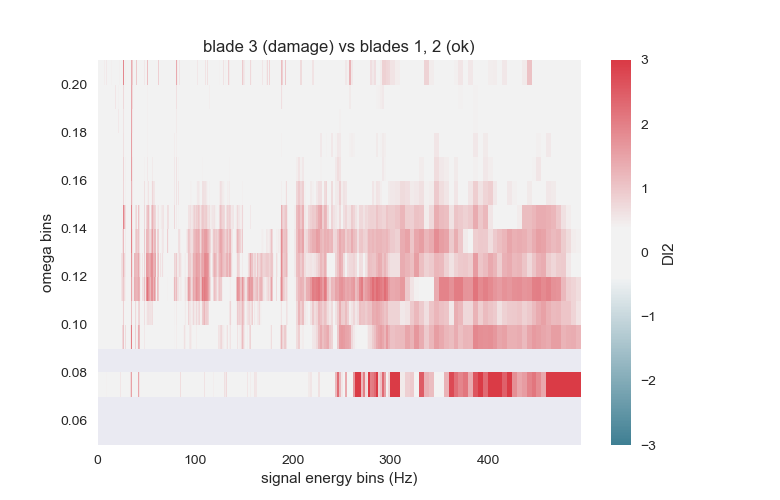

In [673]:
dmg.compute_se_DI2_profile(
    'edge', 'omega_mean', vmin=0.05, vmax=0.21, vstep=0.01,
    difference_statistic='cohen_d', show=dict(vmin=0.4, vmax=3))

<IPython.core.display.Javascript object>


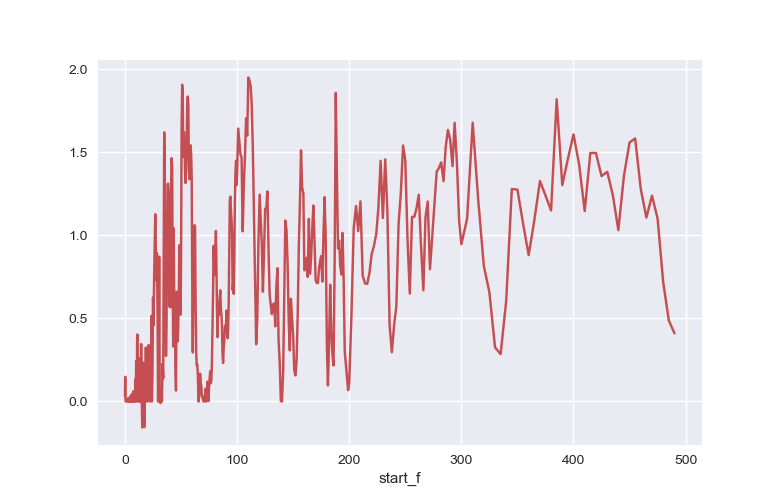

In [676]:
dmg.load_se({'omega_mean': (0.11, 0.13)}, 'edge')
_DI2, _ = dmg.compute_DI2(difference_statistic='cohen_d')

plt.figure()
ax = _DI2.plot()

<IPython.core.display.Javascript object>


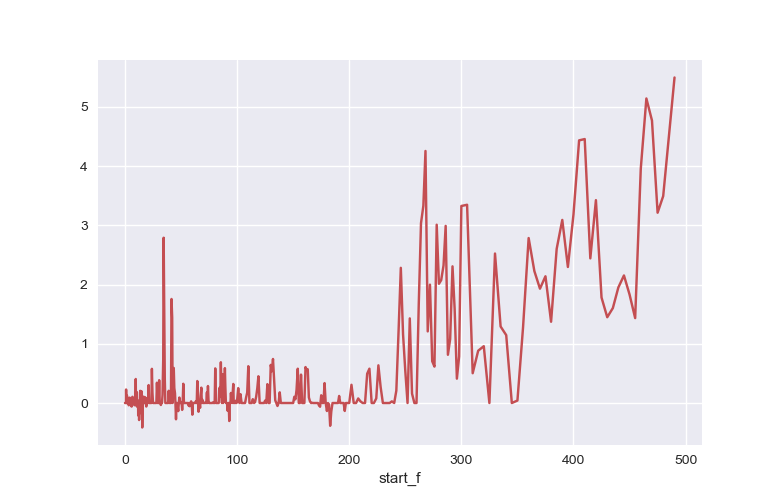

In [675]:
dmg.load_se({'omega_mean': (0.07, 0.08)}, 'edge')
_DI2, _ = dmg.compute_DI2(difference_statistic='cohen_d')

plt.figure()
ax = _DI2.plot()

## Operational state

In [691]:
opstate = {'temperature_mean': (5, ), 'omega_mean': (0.07, 0.08),
           'pitch_mean': (5, 10)}

In [5]:
opstate = {'temperature_mean': (8, 12), 'omega_mean': (0.11, 0.13),
           'pitch_mean': (3.7, 3.9)}

## Normal comparison spectra from other turbines
- properties of this turbine:
    - Vestas V136/3450 Mk3B
    - Getriebe# 271207 (EH922A-C01)
    - Sensorposition 16 m (most other turbines of this type have 20 m)
    - blades: Vestas 67M hybrid
    - sensors: BCA423
- only few other turbines with these properties:

In [6]:
otherdbs = pd.Index(
    ['bc_t_02476', 'bc_t_02477', 'bc_t_02489', 'bc_t_02490'],
    name='dbname')

- these other turbines have sensor defects or blade/turbine damages:

In [7]:
other_defects = {
    'bc_t_02476': {'3_flap': ('2019-02-06', ),
                   '1_edge': ('2019-02-13', )},
    'bc_t_02477': {'2_edge': ('2019-11-29', ),
                   '2_flap': ('2019-11-29', )},
    'bc_t_02489': {'3_edge': ('2018-11-17', ),
                   '3_flap': ('2018-11-17', ),
                   '2_flap': ('2020-04-01', )},
    'bc_t_02490': {'1_edge': ('2017-11-29', ),
                   '1_flap': ('2017-11-29', )}}

In [8]:
stvars = ['azimuth_mean', 'azimuth_sigma', 'omega_mean', 'omega_sigma', 'pitch_mean', 'pitch_sigma', 'power_mean', 'power_sigma',
          'temperature_mean', 'wind_mean', 'wind_sigma']

In [9]:
otherst = []
for _db in otherdbs:
    _where = opstate.copy()
    _where['create_time'] = ('2019-03', '2020-06-05')
    otherst.append(
        weadbs.cdef_query(
            _db, cycle='hour', columns=['create_time'] + stvars, where=_where)
        .set_index('create_time'))
    
otherst = pd.concat(otherst, keys=otherdbs)

In [10]:
ospecs = []
for _db in otherdbs:
    _loader = hdf5.FilterLoader(opstate, 'af', hdfdir.parent.parent / _db)
    ospec, _, _ = _loader.load(('2019', '2020-07'), channels='blades')
    _st = otherst.loc[_db]
    _st.index = _st.index.tz_localize(_loader.origin_tz)
    osed = weadbs.SEData(ospec.astype(float), _st.loc[ospec.index])
    osed.convert_channel_names('{blade}_{ori}')
    
    # set data with defects to NaN
    for _ch, _period in other_defects[_db].items():
        sl = slice(*_period) if len(_period) == 2 else slice(_period[0], None)
        osed.se.loc[sl, _ch] = np.nan
        
    ospecs.append(osed)
    
ospecs = weadbs.SEData.concat(ospecs, otherdbs)

loading ... 100% done.
combining data ... done.
loading ... 100% done.
combining data ... done.
loading ... 100% done.
combining data ... done.
loading ... 100% done.
combining data ... done.


In [11]:
omeans = ospecs.se.groupby(level='dbname').mean().stack('channel').T

## Find peaks in spectrogram

In [631]:
loader_2017 = hdf5.FilterLoader(
    opstate, 'af', hdfdir.parent / 'batch_2017', filterfirst=True)

specs_2017, _ticks, _cts = loader_2017.load(('2017', '2019-10'), channels='blades')

_st = weadbs.cdef_query(
    db, cycle='hour', where={'create_time': set(specs_2017.index)})
_st.set_index('create_time', inplace=True)

specs_2017 = weadbs.SEData(specs_2017, _st)
specs_2017.convert_channel_names('{blade}_{ori}')
specs_2017

loading ... 100% done.
combining data ... done.


signal energies for channels:
[1_edge, 1_flap, 2_edge, 2_flap, 3_edge, 3_flap]
from 2017-12-25 16:23:47 to 2019-02-26 03:21:40
131 rows

In [12]:
loader = hdf5.FilterLoader(opstate, 'af', hdfdir.parent, filterfirst=True)

specs, _ticks, _cts = loader.load(('2019', '2019-10'), channels='blades')
st = weadbs.cdef_query(
    db, cycle='hour', where={'create_time': set(specs.index)})
st.set_index('create_time', inplace=True)
st.index = st.index.tz_localize(loader.origin_tz)

specs = weadbs.SEData(specs, st)
specs.convert_channel_names('{blade}_{ori}')
specs

loading ... 100% done.
combining data ... done.


signal energies for channels:
[1_edge, 1_flap, 2_edge, 2_flap, 3_edge, 3_flap]
from 2019-03-21 10:28:03+01:00 to 2019-09-21 07:25:55+02:00
66 rows

In [13]:
specs_dmg, _ticks, _cts = loader.load(('2019-12-11', '2020'), channels='blades')

_st = weadbs.cdef_query(
    db, cycle='hour', where={'create_time': set(specs_dmg.index)})
_st.set_index('create_time', inplace=True)
_st.index = _st.index.tz_localize(loader.origin_tz)

specs_dmg = weadbs.SEData(specs_dmg, _st)
specs_dmg.convert_channel_names('{blade}_{ori}')
specs_dmg

loading ... 100% done.
combining data ... done.


signal energies for channels:
[1_edge, 1_flap, 2_edge, 2_flap, 3_edge, 3_flap]
from 2019-12-16 06:28:01+01:00 to 2019-12-31 00:13:53+01:00
18 rows

<IPython.core.display.Javascript object>


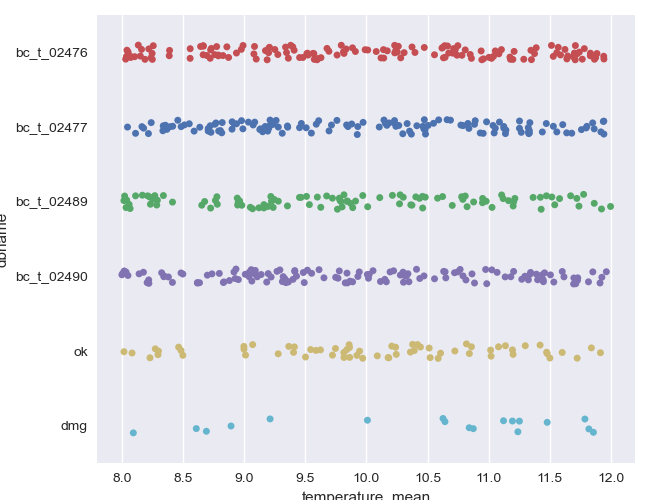

In [14]:
_stvar = 'temperature_mean'
_data = pd.concat(
    [ospecs.st[_stvar], pd.concat([specs.st[_stvar]], keys=['ok']),
     pd.concat([specs_dmg.st[_stvar]], keys=['dmg'])])

fg = sns.catplot(data=_data.reset_index(), y='dbname', x=_stvar, aspect=1.3)

<IPython.core.display.Javascript object>


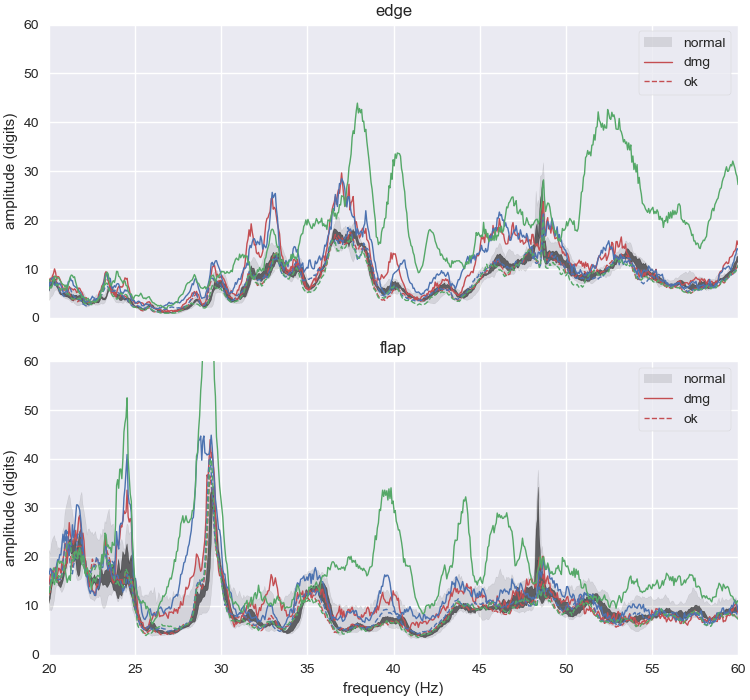

In [15]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True,
                         constrained_layout=True, figsize=(7.5, 7))

for ax, _ori in zip(axes, ('edge', 'flap')):
    ax = plots.quantileband(
        omeans.loc[:, omeans.columns.get_level_values('channel')
                   .str.endswith(_ori)],
        mean=False, color='k', ax=ax)

    mok = specs.select_channels(_ori).se.mean().unstack('channel')
    mdmg = specs_dmg.select_channels(_ori).se.mean().unstack('channel')
    for bl in range(1, 4):
        _ch = specs.info['chform'].format(blade=bl, ori=_ori)
        _ = ax.plot(mok.index, mok[_ch], color=f'C{bl - 1}', lw=1, ls='--', label='ok')
        _ = ax.plot(mdmg.index, mdmg[_ch], color=f'C{bl - 1}', lw=1, label='dmg')
        
    _band = ax.get_children()[0]
    _handles = [
        plt.matplotlib.patches.Patch(facecolor=_band.get_fc()[0], label='normal'),
        plt.matplotlib.lines.Line2D([0], [0], lw=1, color='C0', label='dmg'),
        plt.matplotlib.lines.Line2D([0], [0], lw=1, color='C0', ls='--', label='ok')]
    
    ax.legend(handles=_handles)
    ax.set_title(_ori)
    ax.set_ylabel(f"amplitude ({specs.info['units']})")
    
_ = ax.set_xlabel('frequency (Hz)')

In [709]:
_ = ax.set_xlim(20, 80)
_ = ax.set_ylim(0, 100)

In [17]:
_ = ax.set_xlim(20, 60)
_ = ax.set_ylim(0, 60)

In [215]:
_ = axes[-1].set_xlim(0, 10)
_ = axes[-1].set_ylim(0, 200)

In [16]:
_ = axes[-1].set_xlim(5, 20)
_ = axes[-1].set_ylim(0, 100)

## Damage classifier

In [5]:
stvars = ['azimuth_mean', 'azimuth_sigma', 'omega_mean', 'omega_sigma', 'power_mean', 'power_sigma',
          'temperature_mean', 'wind_mean', 'wind_sigma']

In [6]:
ori = 'flap'

In [7]:
clf = classification.SEDBladeClassifier(
    {'omega_mean': 0}, ori, fbands, fbands.left, normalisation, stvars, 
    intended_for={'Datenbankname': f'cmrblba_{db}'})

In [8]:
train_periods = periods.CompactPeriods(data_periods)

In [9]:
defect_periods = periods.CompactPeriods([])
for _ch in sens_defects:
    if _ch.endswith(ori):
        defect_periods = defect_periods | periods.CompactPeriods(sens_defects[_ch])

In [10]:
dmg_period = periods.TimeInterval(dmg_period)

In [11]:
X, y = clf.load_Xy_from_hdf(
    hdfdir / 'sda_from_specs.h5', f'cmrblba_{db}',
    train_periods - defect_periods - dmg_period, 
    train_periods - defect_periods - ~dmg_period,
    dmg_blade)

loading chunk starting from 2020-06-08 ... done.
shape of loaded X: (14844, 259)


In [14]:
X

f000      f002      f004      f006      f008  \
blade create_time                                                             
1     2019-03-15 16:14:55  0.897955  1.025479  0.987408  1.067281  1.048028   
      2019-03-15 17:31:04  0.870892  1.013270  1.020292  0.982393  0.978448   
      2019-03-15 18:29:33  0.890992  1.082827  1.002082  1.015003  0.932539   
      2019-03-15 21:31:42  0.997020  1.082863  0.973670  1.008801  1.075698   
      2019-03-17 00:31:57  0.929491  1.035474  1.052830  1.093288  1.036612   
...                             ...       ...       ...       ...       ...   
3     2020-06-02 15:29:03  1.431720  2.280338  2.487401  2.503232  2.871516   
      2020-06-02 16:27:24  1.504246  1.716495  1.883184  2.050153  2.691138   
      2020-06-02 23:13:17  1.477992  1.428034  1.806784  1.625605  2.437956   
      2020-06-03 00:30:17  1.552077  1.796606  1.788021  1.862963  2.601488   
      2020-06-03 01:27:54  1.361622  1.937388  2.339934  2.728995  2.783438   

                               f010      f012      f014      f016      f018  \
blade create_time                                                             
1     2019-03-15 16:14:55  1.058616  0.963363  1.074667  1.208271  1.048604   
      2019-03-15 17:31:04  1.021232  1.070502  1.053757  1.062989  0.997381   
      2019-03-15 18:29:33  1.006902  1.042532  0.985329  1.049800  0.949214   
      2019-03-15 21:31:42  1.041677  1.017107  0.939952  1.188005  0.970436   
      2019-03-17 00:31:57  0.955832  1.078743  1.035189  1.025892  0.761416   
...                             ...       ...       ...       ...       ...   
3     2020-06-02 15:29:03  2.515970  2.398739  2.516096  2.361862  2.798239   
      2020-06-02 16:27:24  2.027417  2.031318  2.076510  2.072294  2.635675   
      2020-06-02 23:13:17  1.510566  1.660268  1.543004  1.538940  2.619967   
      2020-06-03 00:30:17  2.030216  1.798979  1.837265  1.900591  2.650112   
      2020-06-03 01:27:54  2.776745  2.815729  2.781320  2.819612  2.900676   

                           ...      f498  azimuth_mean  azimuth_sigma  \
blade create_time          ...                                          
1     2019-03-15 16:14:55  ...  1.069964       268.348   5.863160e-06   
      2019-03-15 17:31:04  ...  0.926054       268.900  -3.542090e-16   
      2019-03-15 18:29:33  ...  1.054740       270.800   4.244650e-16   
      2019-03-15 21:31:42  ...  1.448218       262.800   3.210860e-16   
      2019-03-17 00:31:57  ...  1.192033       245.992   1.121130e-07   
...                        ...       ...           ...            ...   
3     2020-06-02 15:29:03  ...  1.485082       339.700   2.460050e-16   
      2020-06-02 16:27:24  ...  1.405027       339.700   2.460050e-16   
      2020-06-02 23:13:17  ...  2.008924       339.700   2.653040e-16   
      2020-06-03 00:30:17  ...  1.575320       339.700   2.653040e-16   
      2020-06-03 01:27:54  ...  2.721363       339.700   1.611670e-16   

                           omega_mean  omega_sigma  power_mean  power_sigma  \
blade create_time                                                             
1     2019-03-15 16:14:55         0.0          0.0     -7.5600      57.0319   
      2019-03-15 17:31:04         0.0          0.0     -4.0400      89.0975   
      2019-03-15 18:29:33         0.0          0.0     -4.6000      96.2023   
      2019-03-15 21:31:42         0.0          0.0    -16.7308      51.9294   
      2019-03-17 00:31:57         0.0          0.0    -24.6000      17.4844   
...                               ...          ...         ...          ...   
3     2020-06-02 15:29:03         0.0          0.0     -2.0000       0.0000   
      2020-06-02 16:27:24         0.0          0.0     -5.0000       0.0000   
      2020-06-02 23:13:17         0.0          0.0     -2.0000       0.0000   
      2020-06-03 00:30:17         0.0          0.0     -2.0000       0.0000   
      2020-06-03 01:27:54         0.0          0.0     -2.0000       0.0000  